In [1]:
from IPython.core.display import HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import os
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
spark = (SparkSession
  .builder
  .appName("US_Accidents")
  .getOrCreate())

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/10/03 15:28:07 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
schema = StructType([StructField('ID', StringType(), False),
                StructField('Source', StringType(), False),
                StructField('Severity', IntegerType(), False),
                StructField('Start_Time', TimestampType(), False),                  
                StructField('End_Time', TimestampType(), False),      
                StructField('Start_Lat', DecimalType(), False),
                StructField('Start_Lng', DecimalType(), False),
                StructField('End_Lat', DecimalType(), True),
                StructField('End_Lng', DecimalType(), True),       
                StructField('Distance(mi)', DecimalType(), False),       
                StructField('Description', StringType(), False),       
                StructField('Street', StringType(), True),                 
                StructField('City', StringType(), True),       
                StructField('County', StringType(), True),       
                StructField('State', StringType(), True),       
                StructField('Zipcode', StringType(), True),       
                StructField('Country', StringType(), True),       
                StructField('Timezone', StringType(), True),       
                StructField('Airport_Code', StringType(), True),
                StructField('Weather_Timestamp', TimestampType(), True),
                StructField('Temperature(F)', DecimalType(), True),
                StructField('Wind_Chill(F)', DecimalType(), True),
                StructField('Humidity(%)', DecimalType(), True),
                StructField('Pressure(in)', DecimalType(), True),
                StructField('Visibility(mi)', DecimalType(), True),
                StructField('Wind_Direction', StringType(), True),
                StructField('Wind_Speed(mph)', DecimalType(), True),
                StructField('Precipitation(in)', DecimalType(), True),
                StructField('Weather_Condition', StringType(), True),
                StructField('Amenity', BooleanType(), False),
                StructField('Bump', BooleanType(), False),
                StructField('Crossing', BooleanType(), False),
                StructField('Give_way', BooleanType(), False),
                StructField('Junction', BooleanType(), False),
                StructField('No_Exit', BooleanType(), False),
                StructField('Railway', BooleanType(), False), 
                StructField('Roundabout', BooleanType(), False),
                StructField('Station', BooleanType(), False),
                StructField('Stop', BooleanType(), False),
                StructField('Traffic_Calming', BooleanType(), False),
                StructField('Traffic_Signal', BooleanType(), False),
                StructField('Turning_Loop', BooleanType(), False),
                StructField('Sunrise_Sunset', StringType(), True),
                StructField('Civil_Twilight', StringType(), True),
                StructField('Nautical_Twilight', StringType(), True),
                StructField('Astronomical_Twilight', StringType(), True)])

# Use the DataFrameReader interface to read a CSV file
file = "US_Accidents_March23.csv"
df = spark.read.csv(file, header=True, schema=schema)

In [5]:
df = df.select('ID'
               , 'Start_Time'
               , 'End_Time'
               , 'Timezone'
               , 'Weather_Timestamp'
               , 'Weather_Condition'
               , 'Temperature(F)'
               , 'Wind_Chill(F)'
               , 'Humidity(%)'
               , 'Pressure(in)'
               , 'Visibility(mi)'
               , 'Wind_Direction'
               , 'Wind_Speed(mph)'
               , 'Precipitation(in)')
df.show(5)

+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+
| ID|         Start_Time|           End_Time|  Timezone|  Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+
|A-1|2016-02-08 05:46:00|2016-02-08 11:00:00|US/Eastern|2016-02-08 05:58:00|       Light Rain|            37|         null|         91|          30|            10|          Calm|           null|                0|
|A-2|2016-02-08 06:07:59|2016-02-08 06:37:59|US/Eastern|2016-02-08 05:51:00|       Light Rain|            38|         null|        100|          30|

In [6]:
# Get row count
rows = df.count()
print(f"DataFrame Rows count : {rows}")

# Get columns count
cols = len(df.columns)
print(f"DataFrame Columns count : {cols}")

DataFrame Rows count : 7728394
DataFrame Columns count : 14


In [7]:
df.groupBy('Timezone').count().orderBy(desc("count")).show()

+-----------+-------+
|   Timezone|  count|
+-----------+-------+
| US/Eastern|3580167|
| US/Pacific|2062984|
| US/Central|1645616|
|US/Mountain| 431819|
|       null|   7808|
+-----------+-------+



In [8]:
#have to remove the ~8000 rows with null timezone if using date/time in any way
df = df.dropna(subset=["Timezone"])
df.groupBy('Timezone').count().orderBy(desc("count")).show()

+-----------+-------+
|   Timezone|  count|
+-----------+-------+
| US/Eastern|3580167|
| US/Pacific|2062984|
| US/Central|1645616|
|US/Mountain| 431819|
+-----------+-------+



In [9]:
#Null counts (excluding time columns)
df.agg(*[
    (df.count()-count(c)).alias(c)    # vertical (column-wise) operations in SQL ignore NULLs
    for c in df.columns 
]).show()

+---+----------+--------+--------+-----------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+
| ID|Start_Time|End_Time|Timezone|Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|
+---+----------+--------+--------+-----------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+
|  0|         0|       0|       0|           112420|           165651|        156045|      1991211|     166336|      132871|        169290|        167398|         563425|          2195778|
+---+----------+--------+--------+-----------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+



In [10]:
# Convert times to utc in new columns UTC_*
df=df.withColumn("Start_Time",col("Start_Time").cast("Timestamp"))\
.withColumn("UTC_Start_Time",to_utc_timestamp(col("Start_Time"), col("Timezone")))\
.withColumn("End_Time",col("End_Time").cast("Timestamp"))\
.withColumn("UTC_End_Time",to_utc_timestamp(col("End_Time"), col("Timezone")))\
.withColumn("Weather_Timestamp",col("Weather_Timestamp").cast("Timestamp"))\
.withColumn("UTC_Weather_Timestamp",to_utc_timestamp(col("Weather_Timestamp"), col("Timezone")))
df.show(5)

+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+
| ID|         Start_Time|           End_Time|  Timezone|  Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|     UTC_Start_Time|       UTC_End_Time|UTC_Weather_Timestamp|
+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+
|A-1|2016-02-08 05:46:00|2016-02-08 11:00:00|US/Eastern|2016-02-08 05:58:00|       Light Rain|            37|         null|         91|          30|            10|          Ca

In [11]:
# Create Day of the Week Column
df = df.withColumn('Day_of_Week', dayofweek(col('Start_Time'))) #Ranges from 1 for a Sunday through to 7 for a Saturday
df.show(5)

+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+
| ID|         Start_Time|           End_Time|  Timezone|  Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|     UTC_Start_Time|       UTC_End_Time|UTC_Weather_Timestamp|Day_of_Week|
+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+
|A-1|2016-02-08 05:46:00|2016-02-08 11:00:00|US/Eastern|2016-02-08 05:58:00|       Light Rain|            37|         null|         91|    

In [12]:
# Create Month Column
df = df.withColumn('Month', month(df['Start_Time']))
df.show(5)

+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+
| ID|         Start_Time|           End_Time|  Timezone|  Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|     UTC_Start_Time|       UTC_End_Time|UTC_Weather_Timestamp|Day_of_Week|Month|
+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+
|A-1|2016-02-08 05:46:00|2016-02-08 11:00:00|US/Eastern|2016-02-08 05:58:00|       Light Rain|            37|         nul

In [13]:
# Create Season Column
import pyspark.sql.functions as F
df = df.withColumn(
    'Season',
    F.when(F.col("Month").between(3, 5), 'Spring')\
    .when(F.col("Month").between(6, 8), 'Summer')\
    .when(F.col("Month").between(9, 11), 'Fall')\
    .otherwise('Winter'))
df.show(5)

+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+------+
| ID|         Start_Time|           End_Time|  Timezone|  Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|     UTC_Start_Time|       UTC_End_Time|UTC_Weather_Timestamp|Day_of_Week|Month|Season|
+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+------+
|A-1|2016-02-08 05:46:00|2016-02-08 11:00:00|US/Eastern|2016-02-08 05:58:00|       Light Rain|      

In [14]:
# Create Rush Hour Column
# defined as 6-9am and 4-7pm (https://www.goldlaw.com/how-deadly-is-rush-hour/)
df = df.withColumn('Start_Time_Time', date_format('Start_Time', 'HH:mm:ss'))
df.show(5)
df = df.withColumn(
    'Rush Hour',
    F.when(F.col('Start_Time_Time').between('06:00:00', '09:00:00'), 1)\
    .when(F.col('Start_Time_Time').between('16:00:00', '19:00:00'), 1)\
    .otherwise(0))
df.show(5)

+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+------+---------------+
| ID|         Start_Time|           End_Time|  Timezone|  Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|     UTC_Start_Time|       UTC_End_Time|UTC_Weather_Timestamp|Day_of_Week|Month|Season|Start_Time_Time|
+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+------+---------------+
|A-1|2016-02-08 05:46:00|2016-02-08 11:00:00|US/East

In [15]:
# Create Date Column from Start Date
df = df.withColumn('Start_Date_Date', date_format('Start_Time', 'yyyy-MM-dd'))

#Create list of holiday dates for span of data (2016-2023)
#!pip3 install holidays
import holidays
from datetime import datetime, timezone
h = []
for ptr in holidays.UnitedStates(years = [2016,2017,2018,2019,2020,2021,2022,2023]).items(): 
    h.append(ptr[0].strftime("%Y-%m-%d"))

# Create Holiday column    
df = df.withColumn(
    'Holiday',
    F.when(array_contains(lit(h), F.col("Start_Date_Date")), 1)\
    .otherwise(0))
df.show(5) 

+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+------+---------------+---------+---------------+-------+
| ID|         Start_Time|           End_Time|  Timezone|  Weather_Timestamp|Weather_Condition|Temperature(F)|Wind_Chill(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|     UTC_Start_Time|       UTC_End_Time|UTC_Weather_Timestamp|Day_of_Week|Month|Season|Start_Time_Time|Rush Hour|Start_Date_Date|Holiday|
+---+-------------------+-------------------+----------+-------------------+-----------------+--------------+-------------+-----------+------------+--------------+--------------+---------------+-----------------+-------------------+-------------------+---------------------+-----------+-----+------+-

In [16]:
# Weather Condition

In [17]:
df.select('Weather_Condition').distinct().count()

145

In [18]:
df.select('Weather_Condition').distinct().show(5, truncate = False)
#Could create Binary columns for a few features where words like Fog, Snow, etc. are included

#'Ice', 'Snow', 'Hail', 'Sleet'
#'Fog', 'Dust', 'Ash', 'Smoke', 'Haze', 'Sand'

+-----------------+
|Weather_Condition|
+-----------------+
|Ice Pellets      |
|Shallow Fog      |
|Thunderstorm     |
|Volcanic Ash     |
|N/A Precipitation|
+-----------------+
only showing top 5 rows



In [19]:
df.groupBy('Weather_Condition').count().orderBy(desc("count")).show(10)

+-----------------+-------+
|Weather_Condition|  count|
+-----------------+-------+
|             Fair|2560802|
|    Mostly Cloudy|1016195|
|           Cloudy| 817082|
|            Clear| 808743|
|    Partly Cloudy| 698972|
|         Overcast| 382866|
|       Light Rain| 352957|
| Scattered Clouds| 204829|
|             null| 165651|
|       Light Snow| 128680|
+-----------------+-------+
only showing top 10 rows



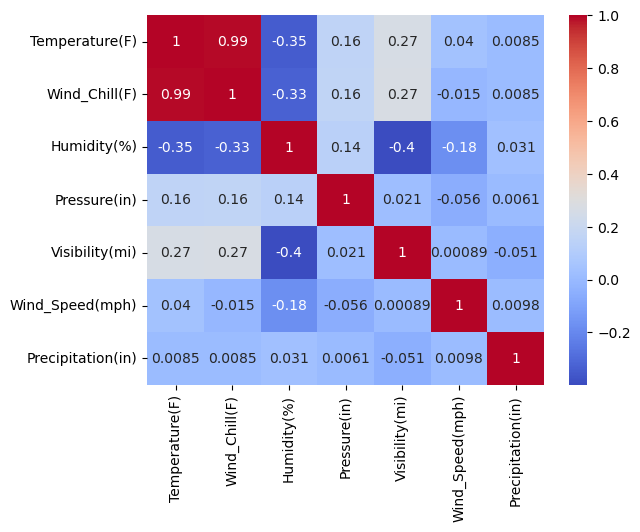

In [36]:
# Create sample data
df1 = df.select('Temperature(F)'
               , 'Wind_Chill(F)'
               , 'Humidity(%)'
               , 'Pressure(in)'
               , 'Visibility(mi)'
               #, 'Wind_Direction'
               , 'Wind_Speed(mph)'
               , 'Precipitation(in)')
df1 = dataset.na.drop()

# Assemble features into a vector column
assembler = VectorAssembler(inputCols=['Temperature(F)'
               , 'Wind_Chill(F)'
               , 'Humidity(%)'
               , 'Pressure(in)'
               , 'Visibility(mi)'
               #, 'Wind_Direction'
               , 'Wind_Speed(mph)'
               , 'Precipitation(in)'], outputCol="features")
df_vector = assembler.transform(df1)

# Calculate the correlation matrix
correlation_matrix = Correlation.corr(df_vector, "features").head()[0]

# Turn into a dataframe
corr_matrix_pd = pd.DataFrame(correlation_matrix.toArray(), columns=df1.columns, index=df1.columns)

#Plot
sns.heatmap(corr_matrix_pd, annot=True, cmap="coolwarm")
plt.show()